In [1]:
class color:
    BOLD = '\033[1m'
    END = '\033[0m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import datetime as dt
import pickle as pkl
import seaborn as sns
import re

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

import sagemaker
import boto3
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator
import smdebug

In [3]:
role = get_execution_role()
region = boto3.Session().region_name

In [4]:
!pip freeze | grep smdebug

smdebug==0.7.2
smdebug-rulesconfig==0.1.2


In [5]:
#!python -m pip install smdebug

# 0. Get data location from DynamoDB and prep data channels

In [6]:
dynamo_bucket_table = boto3.resource('dynamodb', region_name=region).Table('taxi_training_data_location')
dynamodb_response = dynamo_bucket_table.get_item(Key={'bucketid': 'validation'})

In [7]:
bucket = 'aws-emr-resources-507786327009-us-east-1'
prefix = str(dynamodb_response['Item']['prefix'])

In [8]:
print(f'Data is in {color.BOLD}s3://{bucket}/{prefix}{color.END} S3 bucket.')

Data is in s3://aws-emr-resources-507786327009-us-east-1/taxidata_v20200426171716 S3 bucket.


In [9]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

# 1. Make the model

## 1.1. Adding Hooks

In [10]:
debugger_bucket_path = f's3://{bucket}/debugger_bucket_path'
save_interval = 3

In [11]:
bbb_debugger_hook_config=DebuggerHookConfig(
        s3_output_path=debugger_bucket_path,
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    )

## 1.2. Adding Rules

In [12]:
"""bbb_custom_rule = Rule.custom(
    name='CustomNonTrainingRule',
    image_uri='759209512951.dkr.ecr.us-west-2.amazonaws.com/sagemaker-debugger-rule-evaluator:latest', 
    instance_type='ml.t3.medium',
    source='rules/my_custom_rule.py',
    rule_to_invoke='CustomNonTrainingRule',
    volume_size_in_gb=30,
    collections_to_save=[CollectionConfig("metrics")], 
    # collections to be analyzed by the rule. since this is a first party collection we fetch it as above
    rule_parameters={
      "threshold": "5", "step_pace": "3"
    }
)"""

'bbb_custom_rule = Rule.custom(\n    name=\'CustomNonTrainingRule\',\n    image_uri=\'759209512951.dkr.ecr.us-west-2.amazonaws.com/sagemaker-debugger-rule-evaluator:latest\', \n    instance_type=\'ml.t3.medium\',\n    source=\'rules/my_custom_rule.py\',\n    rule_to_invoke=\'CustomNonTrainingRule\',\n    volume_size_in_gb=30,\n    collections_to_save=[CollectionConfig("metrics")], \n    # collections to be analyzed by the rule. since this is a first party collection we fetch it as above\n    rule_parameters={\n      "threshold": "5", "step_pace": "3"\n    }\n)'

In [13]:
bbb_rules = [
    Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
]

## 1.3. Setting Hyperparameters

In [14]:
hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "silent": "0",
    "objective": "reg:squarederror",
    "num_round": "30",
    "eval_metric":"rmse"
}

## 1.4. Building the image

In [15]:
sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost', '0.90-2')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess,
                                    debugger_hook_config = bbb_debugger_hook_config,
                                    rules=bbb_rules,
                                    hyperparameters=hyperparameters)

In [16]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}, \
       wait=False)

# 2. Model training monitoring

In [17]:
import time
from time import gmtime, strftime


# Below command will give the status of training job
job_name = xgb.latest_training_job.name
client = xgb.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
print('Training job name: ' + job_name)

if description['TrainingJobStatus'] != 'Completed':
    while description['SecondaryStatus'] not in ['Training', 'Completed']:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description['TrainingJobStatus']
        secondary_status = description['SecondaryStatus']
        print("{}: {}, {}".format(strftime('%X', gmtime()), primary_status, secondary_status))
        time.sleep(10)
else:
    print(description['TrainingJobStatus'])

Training job name: sagemaker-xgboost-2020-04-30-12-18-16-286
12:18:19: InProgress, Starting
12:18:29: InProgress, Starting
12:18:39: InProgress, Starting
12:18:49: InProgress, Starting
12:19:00: InProgress, Starting
12:19:10: InProgress, Starting
12:19:20: InProgress, Starting
12:19:30: InProgress, Starting
12:19:40: InProgress, Starting
12:19:50: InProgress, Starting
12:20:00: InProgress, Starting
12:20:10: InProgress, Starting
12:20:20: InProgress, Starting
12:20:30: InProgress, Starting
12:20:40: InProgress, Starting
12:20:50: InProgress, Downloading
12:21:00: InProgress, Downloading
12:21:10: InProgress, Downloading
12:21:20: InProgress, Downloading
12:21:30: InProgress, Training


## 2.1. Observe rules

#### Next few cells will execute after the status of the training job changes to 'InProgress, Training'.

In [22]:
xgb.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:507786327009:processing-job/sagemaker-xgboost-2020-04--lossnotdecreasing-4b6c5c13',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 4, 30, 12, 28, 50, 88000, tzinfo=tzlocal())}]

In [23]:
latest_job_summ_ = xgb.latest_training_job.rule_job_summary()

for x, y in zip([latest_job_summ_[i]['RuleConfigurationName'] for i in range(len(latest_job_summ_))], \
                [latest_job_summ_[i]['RuleEvaluationStatus'] for i in range(len(latest_job_summ_))]):
    print(f'Status of \'{x}\' rule: \'{y}\'.')

Status of 'LossNotDecreasing' rule: 'NoIssuesFound'.


## 2.2. Create Trials

In [24]:
from smdebug.trials import create_trial

description = client.describe_training_job(TrainingJobName=job_name)
s3_output_path = xgb.latest_job_debugger_artifacts_path()

# This is where we create a Trial object that allows access to saved tensors.
trial = create_trial(s3_output_path)

[2020-04-30 12:29:17.331 ip-172-16-61-92:23480 INFO s3_trial.py:42] Loading trial debug-output at path s3://aws-emr-resources-507786327009-us-east-1/debugger_bucket_path/sagemaker-xgboost-2020-04-30-12-18-16-286/debug-output


### The cell below shows everything that the Debugger saves (in the 'tensor_names' list)

In [25]:
trial

[2020-04-30 12:29:18.988 ip-172-16-61-92:23480 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-04-30 12:29:20.008 ip-172-16-61-92:23480 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7ff38118bf60>:(
    name=debug-output,
    path=s3://aws-emr-resources-507786327009-us-east-1/debugger_bucket_path/sagemaker-xgboost-2020-04-30-12-18-16-286/debug-output/,
    steps=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27],
    collections=['hyperparameters', 'metrics', 'predictions', 'labels', 'feature_importance', 'average_shap', 'full_shap', 'trees', 'default', 'losses'],
    tensor_names=['average_shap/f0', 'average_shap/f1', 'average_shap/f10', 'average_shap/f11', 'average_shap/f12', 'average_shap/f13', 'average_shap/f14', 'average_shap/f15', 'average_shap/f16', 'average_shap/f17', 'average_shap/f18', 'average_shap/f2', 'average_shap/f3', 'average_shap/f4', 'average_shap/f5', 'average_shap/f6', 'average_shap/f7', 'average_shap/f8', 'average_shap/f9', 'feature_importance/cover/f1', 'feature_importance/cover/f10', 'feature_importance/cover/f12', 'feature_importance/cover/f14', 'feature_importance/cover/f2', 'feature_importance/cover/f3', 'fea

### 2.2.1. Make sure you save the path for later access - e.g. in DynamoDB

In [26]:
print(f'Trial S3 path: {color.BOLD}{trial.path}{color.END}')

Trial S3 path: s3://aws-emr-resources-507786327009-us-east-1/debugger_bucket_path/sagemaker-xgboost-2020-04-30-12-18-16-286/debug-output/


### 2.2.2. Example of getting information for a specific tensor at a specific step

In [27]:
example_tensor_name_ = 'train-rmse'
example_tensor_step_ = 15
print(f'Tensor \'{example_tensor_name_}\' at step {example_tensor_step_}: {trial.tensor(example_tensor_name_).values()[example_tensor_step_][0]}')

Tensor 'train-rmse' at step 15: 0.131604


## 2.3. Monitoring

In [39]:
def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

In [40]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

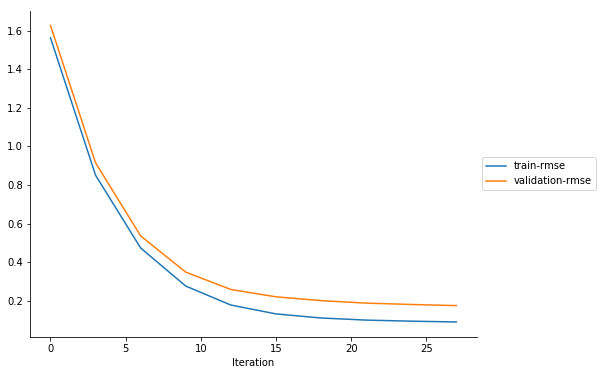

In [41]:
plot_collection(trial, "metrics")

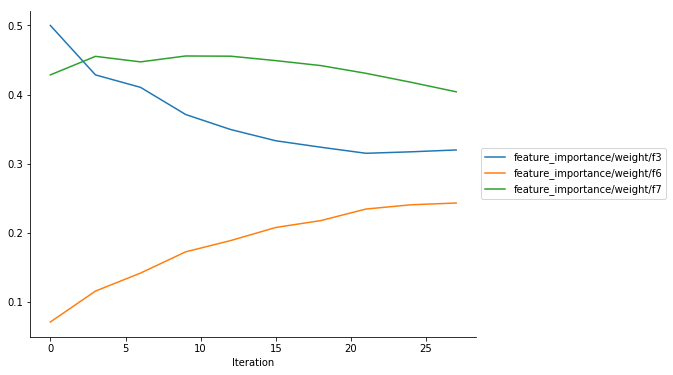

In [42]:
plot_feature_importance(trial, importance_type='weight')

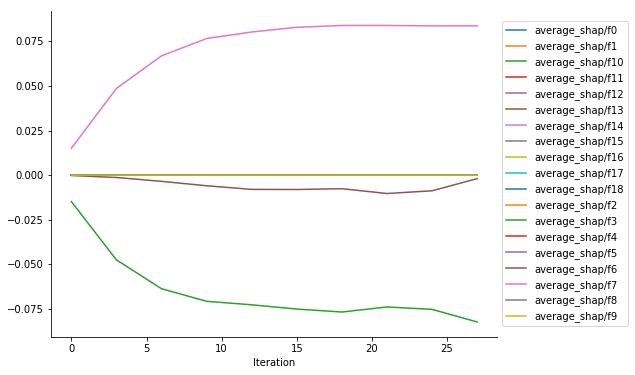

In [43]:
plot_collection(trial, "average_shap")

# 3. Test

## 3.1. Deploy the model to SageMaker endpoint

In [44]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

---------------!

In [45]:
test_file_ = 'part-00000-30faa406-54e6-43a3-895e-07b4caa237d9-c000.csv'

In [46]:
test_bucket_ = 's3://{}/{}/test/test.csv/{}'.format(bucket, prefix, test_file_)

In [ ]:
!aws s3 cp $test_bucket_ .

In [47]:
test_data_df = pd.read_csv(test_file_, header=None).head(500)

In [48]:
test_data_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.36,5,4.60,1,26.16,1,1.0,21.0,0.2076,2,7,21,2,7,49,4.6750,0.9840,1,0,1
1,0.00,1,0.55,1,5.80,1,1.0,5.0,0.0000,2,7,39,2,7,44,0.8528,0.6449,1,0,1
2,5.20,1,2.78,1,22.54,1,1.0,11.0,0.4727,2,7,46,2,7,59,2.2583,1.2310,1,0,1
3,0.00,1,0.59,1,4.80,2,1.0,4.0,0.0000,2,7,54,2,7,56,0.4278,1.3791,1,0,1
4,0.00,2,5.06,1,22.30,2,1.0,21.5,0.0000,2,7,27,2,7,55,4.5444,1.1135,1,0,1


## 3.2. Predict the test data (500 rows)

In [49]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [50]:
predictions = predict(test_data_df.values[:, 1:])

In [51]:
results_df = pd.DataFrame({'real': list(test_data_df.iloc[:, 0]), 'predicted':predictions})
results_df['predicted'] = results_df['predicted'].apply(lambda x: max(0, round(x, 2)))
results_df['diff'] = abs(results_df['predicted'] - results_df['real'])

def diff_as_pct_fn(x, y):
    return int(round(100*x/y, 0)) if y > 0 else 0
results_df['diff_as_pct'] = results_df.apply(lambda row: diff_as_pct_fn(row['diff'], row['real']), axis=1)

In [52]:
results_df.head(10)

,real,predicted,diff,diff_as_pct
0,4.36,4.28,0.08,2
1,0.00,0.00,0.00,0
2,5.20,6.05,0.85,16
3,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0
5,16.70,18.43,1.73,10
6,1.70,1.71,0.01,1
7,0.00,0.00,0.00,0
8,0.00,0.00,0.00,0
9,1.20,1.14,0.06,5


In [53]:
print(f"RMSE: {mean_squared_error(list(results_df['predicted']), list(results_df['real']))**.5:,.4f}")

RMSE: 0.1162


In [54]:
dev_threshold = 5

print(f'Percent predictions in which the deviation is less than {dev_threshold}% from the real \
data: {100*results_df[results_df.diff_as_pct <= dev_threshold].shape[0] / results_df.shape[0]:,.2f}%.')

Percent predictions in which the deviation is less than 5% from the real data: 94.20%.
